In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("train.csv")
display(df.head())
display(df.shape)

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


(20758, 18)

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay

In [5]:
for column in df.columns:
    if len(df[column].unique()) < 10:
        print(column, df[column].unique())
        print()

Gender ['Male' 'Female']

family_history_with_overweight ['yes' 'no']

FAVC ['yes' 'no']

CAEC ['Sometimes' 'Frequently' 'no' 'Always']

SMOKE ['no' 'yes']

SCC ['no' 'yes']

CALC ['Sometimes' 'no' 'Frequently']

MTRANS ['Public_Transportation' 'Automobile' 'Walking' 'Motorbike' 'Bike']

NObeyesdad ['Overweight_Level_II' 'Normal_Weight' 'Insufficient_Weight'
 'Obesity_Type_III' 'Obesity_Type_II' 'Overweight_Level_I'
 'Obesity_Type_I']



In [6]:
cat = df.select_dtypes(include=['object']).columns.drop('NObeyesdad')
print(cat)

Index(['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE',
       'SCC', 'CALC', 'MTRANS'],
      dtype='object')


In [7]:
X_transform = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=5), cat)
    ],
    remainder = 'passthrough'
)

y_transform = LabelEncoder()

In [9]:
y_transform

LabelEncoder()

In [11]:
pip install optuna



     -------------------------------------- 413.4/413.4 kB 8.8 MB/s eta 0:00:00
     ------------------------------------- 233.4/233.4 kB 13.9 MB/s eta 0:00:00
     ---------------------------------------- 78.7/78.7 kB ? eta 0:00:00


In [18]:
X = df.drop(['id', 'NObeyesdad'], axis=1)
y = df['NObeyesdad']
X = X_transform.fit_transform(X)
y = y_transform.fit_transform(y)

In [19]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 15),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True)
    }
    
    model = XGBClassifier(**params, objective='multi:softmax', random_state=42)
    
    valid_scores = cross_val_score(model, X, y, scoring='accuracy')
    
    return np.mean(valid_scores)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, show_progress_bar=True)
print(study.best_params)

  0%|          | 0/100 [00:00<?, ?it/s]

{'learning_rate': 0.052106292658608847, 'max_depth': 13, 'subsample': 0.8933548807293723, 'n_estimators': 486, 'colsample_bytree': 0.40106732202747924, 'reg_lambda': 0.5776458497750607, 'reg_alpha': 0.8301240509274177, 'min_child_weight': 3, 'gamma': 0.1805495184772987}


In [21]:
best_params={'learning_rate': 0.052106292658608847, 'max_depth': 13, 'subsample': 0.8933548807293723, 'n_estimators': 486, 'colsample_bytree': 0.40106732202747924, 'reg_lambda': 0.5776458497750607, 'reg_alpha': 0.8301240509274177, 'min_child_weight': 3, 'gamma': 0.1805495184772987}
model = XGBClassifier(**best_params, objective='multi:softmax', random_state=42)

In [22]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.40106732202747924, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.1805495184772987,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.052106292658608847,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=13, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=486, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [23]:
model.score(X_train, y_train)

0.970131277851379

In [24]:
model.score(X_valid, y_valid)

0.9111271676300579

In [25]:
feat = pd.DataFrame({'features': df.columns.drop(['id', 'NObeyesdad']), 'importance': model.feature_importances_})
feat

,features,importance
0,Gender,0.178122
1,Age,0.094261
2,Height,0.043521
3,Weight,0.061897
4,family_history_with_overweight,0.012546
5,FAVC,0.029877
6,FCVC,0.049310
7,NCP,0.037847
8,CAEC,0.047347
9,SMOKE,0.035464


<Axes: xlabel='importance', ylabel='features'>

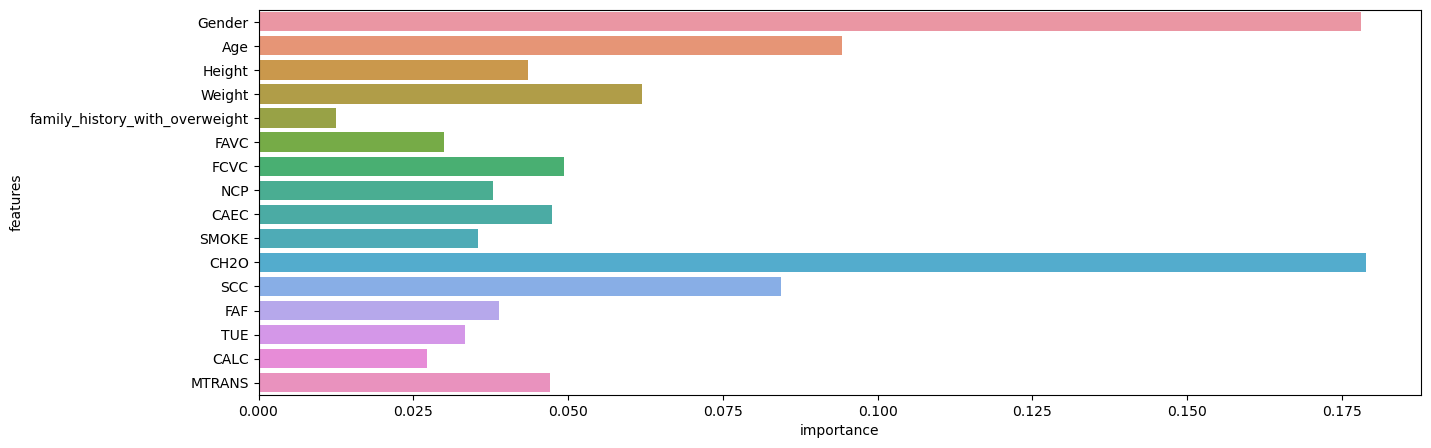

In [26]:
plt.figure(figsize=(15, 5))
plt.xlabel('Importance')
plt.ylabel('Features')
sns.barplot(feat, x='importance', y='features')

In [27]:
df_test = pd.read_csv('test.csv')
df_test.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,20758,Male,26.899886,1.848294,120.644178,yes,yes,2.938616,3.000000,Sometimes,no,2.825629,no,0.855400,0.000000,Sometimes,Public_Transportation
1,20759,Female,21.000000,1.600000,66.000000,yes,yes,2.000000,1.000000,Sometimes,no,3.000000,no,1.000000,0.000000,Sometimes,Public_Transportation
2,20760,Female,26.000000,1.643355,111.600553,yes,yes,3.000000,3.000000,Sometimes,no,2.621877,no,0.000000,0.250502,Sometimes,Public_Transportation
3,20761,Male,20.979254,1.553127,103.669116,yes,yes,2.000000,2.977909,Sometimes,no,2.786417,no,0.094851,0.000000,Sometimes,Public_Transportation
4,20762,Female,26.000000,1.627396,104.835346,yes,yes,3.000000,3.000000,Sometimes,no,2.653531,no,0.000000,0.741069,Sometimes,Public_Transportation


In [31]:
test = pd.read_csv('test.csv')
sub = pd.read_csv('sample_submission.csv')

In [32]:
X_test = test.drop('id', axis=1)
X_test = X_transform.transform(X_test)
y_pred = model.predict(X_test)

In [33]:
y_pred

array([3, 5, 4, ..., 0, 1, 3])

In [34]:
sub['NObeyesdad'] = y_transform.inverse_transform(y_pred)

In [35]:
sub

,id,NObeyesdad
0,20758,Obesity_Type_II
1,20759,Overweight_Level_I
2,20760,Obesity_Type_III
3,20761,Obesity_Type_I
4,20762,Obesity_Type_III
...,...,...
13835,34593,Overweight_Level_II
13836,34594,Overweight_Level_I
13837,34595,Insufficient_Weight
13838,34596,Normal_Weight


In [36]:
sub.to_csv('submissiondavxgbhyper.csv', index=False)